# Zpětnovazební učení

V tomto cvičení budeme pracovat s Open AI gym, což je open source rozhraní určené pro úkoly zpětnovazebního učení. Jeho hlavní výhodou je, že implementace různých typů algoritmů pro zpětnovazební učení je v něm celkem jednoduchá. Popis základních funkcí Open AI gym se nachází v kódu níž.

Dnešní úkol bude naimplementovat agenta, který se učí chovat v nějakém prostředí (konkrétně v MountainCar) pomocí Q-učení.

Q-učení je způsob, kdy se agent učí svou strategii, jak se chovat v daném prostředí, pomocí zpětné vazby, kterou od prostředí za své chování dostává. Na rozdíl od hladového agenta, který jen v každém stavu vybírá nový stav na základě akce, co maximalizuje jeho užitek, bere v potaz to, že mezi stavy existují vztahy, které jsou dány Bellmanovými rovnicemi.

Nyní se tedy podíváme na příklad autíčka,které se snaží dostat do cíle, ale zatím se pohybuje náhodně.

In [1]:
import gym
import numpy as np
import utils
import matplotlib.pyplot as plt

Ukážeme si, jak si vytvořit jednoduché prostředí *MountainCar*: https://gym.openai.com/envs/MountainCar-v0. 

Cílem je, aby se autíčko dostalo z údolí až nahoru k vlaječce, ale nemá dost silný motorek, takže se musí nejprve rozhoupat, aby tam vyjelo. V této základní verzi je zde v každém stavu náhodně zvolena akce pro pohyb.

In [2]:
env = gym.make('MountainCar-v0')
env.reset()
for i in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

Jen tak pro zajímavost existuje i například prostředí *CartPole*, kde je zase cílem vyvažovat tyčku, aby nespadla.

In [3]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

c:\users\katie\onedrive\dokumenty\documents\skola\matfyz\phd\prirodou-inspirovane-algoritmy\02_zpetnovazebne_uceni\gym\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Vrátíme se zpět k *MountainCar*. Použijeme kódu výše a vytvoříme si do něj třídu pro agenta, který se v prostředí zatím bude chovat náhodně, což nám sice v tuto chvíli nepřinese nic užitečného, ale můžete ho později použít jako základ pro zpětnovazebního agenta. 

Stav agenta dvojice je pozice a rychlost, akce může být pohyb vlevo, vpravo a nebo se nepohnout. Agent bude mít dvě metody, jednu na to, aby věděl, jak se má chovat a druhou aby se uměl resetovat. Agenta totiž budeme trénovat v několika iteracích. Pro zajímavost si také vypíšeme, jak vypadá prostředí, ve kterém se agent pohybuje.

In [4]:
# Obecna trida pro agenta
class RandomAgent:
    def __init__(self, actions):
        self.actions = actions
        self.train = True
    
    def act(self, observe, reward, done):
        return self.actions.sample()
    
    def reset(self):
        pass

env = gym.make('MountainCar-v0')

# Prostoru pozorovani a akci
print('observation space:', env.observation_space)
print('observation space low:', env.observation_space.low)
print('observation space high:', env.observation_space.high)
print('action space:', env.action_space)

observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
observation space low: [-1.2  -0.07]
observation space high: [0.6  0.07]
action space: Discrete(3)


Nyní si zkusíme napsat trénovací cyklus. Každá iterace for cyklu je jedna hra s novým náhodným začátkem (kolem minima). Ve while cyklu se trénují přechody mezi stavy agenta. Zároveň si pamatujeme celkovou odměnu a číslo kroku (jeden krok je provedení jedné akce), které se nám bude hodit pro logování trénovacích cyklu. K tomu, aby se agent mohl něco učit musí získávat od prostředí nějakou odměnu. V tomto příkladu by měl agent dostávat v každém kroku odměnu -1, když není v cílovém stavu a 0 pokud v něm je. Snižující se suma odměn totiž agenta nutí, aby prohledával prostředí, a tedy vyjel nahoru co nejdříve.

In [5]:
agent = RandomAgent(env.action_space)
total_rewards = []
for i in range(1000):
    obs = env.reset()
    agent.reset()    
    done = False
    
    r = 0
    R = 0 # celkova odmena - jen pro logovani
    t = 0 # cislo kroku - jen pro logovani
    
    while not done:
        action = agent.act(obs, r, done)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
        
    total_rewards.append(R)    
agent.train = False

Nyní si zobrazíme animaci a graf učení, abychom viděli, jak se náš agent učil. Vidíme, že se moc neučil, což dává smysl, protože nemá implementované žádné rozumné učící se tělo (akce se vybírají náhodně). 

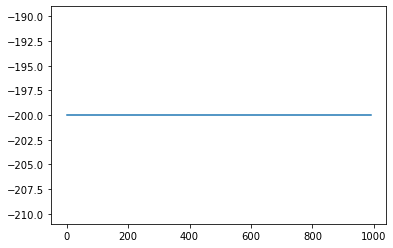

In [6]:
utils.show_animation(agent, env, steps=1000, episodes=5)
plt.plot(utils.moving_average(total_rewards, 10))
plt.show() 

env.close()

## Úkol na cvičení

Zkuste si místo náhodného agenta naprogramovat třídu agenta, který se učí chovat v prostředí MountainCar pomocí Q-učení. Dejte pozor na to, že prostředí vrací jako stav spojité hodnoty (poloha i rychlost jsou obě spojité), takže je třeba si z nich nějak udělat prostředí diskrétní (tedy s konečným množstvím stavů). Čím menší budou diskretizované intervaly, tím bude učení přesnější, ale tím déle bude trvat, takže je potřeba najít nějakou rozumnou hranici (ideálně vyzkoušením více hodnot). Dále můžete také experimentovat s dalšími parametry, například měnit maximální počty kroků, případně hodnotu odměny a pozorovat, jak se bude učení měnit.